In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

In [6]:
from pathlib import Path

dataset_path = Path(r"C:\Users\chinn\OneDrive\Desktop\uptoskills\colored_images")

print(dataset_path)


C:\Users\chinn\OneDrive\Desktop\uptoskills\colored_images


In [7]:
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path correctly
dataset_path = Path(r"C:\Users\chinn\OneDrive\Desktop\uptoskills\colored_images")

# Define transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),  # Convert to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize to range [-1, 1]
])

# Load dataset
dataset = datasets.ImageFolder(root=str(dataset_path), transform=transform)

# Check class names
print("Classes:", dataset.classes)  # ['mild', 'moderate', 'no_dr', 'proliferate_dr', 'severe']

# Create DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get a sample batch
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)  # (batch_size, channels, height, width)
print("Labels:", labels)  # Tensor of class indices


c:\Users\chinn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Batch shape: torch.Size([32, 3, 256, 256])
Labels: tensor([2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 4, 0, 0, 2, 1, 1, 2, 2, 4, 2,
        1, 1, 1, 2, 1, 2, 2, 2])


In [8]:
# number of classes
NUMBER_OF_CLASSES = len(set(dataset.targets))

In [9]:
print(f"Number of classes: {NUMBER_OF_CLASSES}")

Number of classes: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7411765].


Label : Mild


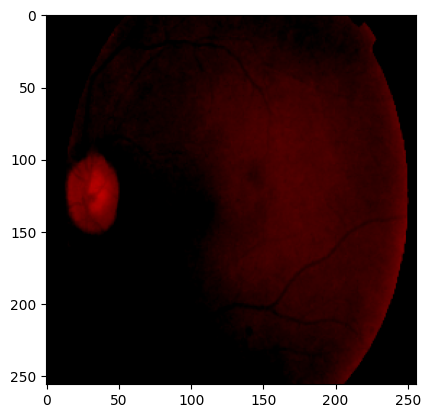

In [11]:
import matplotlib.pyplot as plt

def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))


# display the first image in the dataset
display_image(*dataset[0])

In [12]:
import torch
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset

In [13]:
import torch
train_dataset, test_dataset = train_test_split(dataset, 0.8)

In [17]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

In [18]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, number_of_classes):
        super(CNN, self).__init__()
        
        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, number_of_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # Max pooling layer
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # Max pooling layer
        x = x.view(-1, 64 * 64 * 64)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [22]:
model = CNN(NUMBER_OF_CLASSES)

In [23]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"

In [30]:
import torch
import numpy as np
from torchmetrics.classification import Accuracy
from tqdm import tqdm

# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, device, NUMBER_OF_CLASSES):
    model.to(device)
    
    # Initialize lists to store losses
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    # Initialize accuracy metric
    accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accuracy = []

        # Training loop
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            # Update accuracy
            train_accuracy.append(accuracy(outputs, targets).item())

        # Calculate average train loss and accuracy
        train_loss = np.mean(train_loss)
        train_accuracy = np.mean(train_accuracy)

        # Validation loop
        model.eval()
        test_loss = []
        test_accuracy = []

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss.append(loss.item())

                # Update accuracy
                test_accuracy.append(accuracy(outputs, targets).item())

        # Calculate average test loss and accuracy
        test_loss = np.mean(test_loss)
        test_accuracy = np.mean(test_accuracy)

        # Save losses for each epoch
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        # Print the metrics for the epoch
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses


In [32]:
# Assuming you have already defined device (GPU/CPU) and NUMBER_OF_CLASSES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUMBER_OF_CLASSES = 5  # Change this to the actual number of classes in your dataset

train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10, device=device, NUMBER_OF_CLASSES=NUMBER_OF_CLASSES
)


Validating... Epoch: 1/10: 100%|██████████| 23/23 [00:18<00:00,  1.26it/s]


Epoch 1/10:
Train Loss: 0.85, Train Accuracy: 0.70
Test Loss: 0.81, Test Accuracy: 0.72
------------------------------


Validating... Epoch: 2/10: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


Epoch 2/10:
Train Loss: 0.76, Train Accuracy: 0.72
Test Loss: 0.87, Test Accuracy: 0.69
------------------------------


Validating... Epoch: 3/10: 100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


Epoch 3/10:
Train Loss: 0.73, Train Accuracy: 0.73
Test Loss: 0.83, Test Accuracy: 0.70
------------------------------


Validating... Epoch: 4/10: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


Epoch 4/10:
Train Loss: 0.68, Train Accuracy: 0.74
Test Loss: 0.89, Test Accuracy: 0.70
------------------------------


Validating... Epoch: 5/10: 100%|██████████| 23/23 [00:18<00:00,  1.28it/s]


Epoch 5/10:
Train Loss: 0.64, Train Accuracy: 0.77
Test Loss: 0.92, Test Accuracy: 0.70
------------------------------


Validating... Epoch: 6/10: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


Epoch 6/10:
Train Loss: 0.56, Train Accuracy: 0.80
Test Loss: 1.00, Test Accuracy: 0.70
------------------------------


Validating... Epoch: 7/10: 100%|██████████| 23/23 [00:18<00:00,  1.23it/s]


Epoch 7/10:
Train Loss: 0.50, Train Accuracy: 0.81
Test Loss: 1.19, Test Accuracy: 0.69
------------------------------


Validating... Epoch: 8/10: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


Epoch 8/10:
Train Loss: 0.46, Train Accuracy: 0.84
Test Loss: 1.12, Test Accuracy: 0.70
------------------------------


Validating... Epoch: 9/10: 100%|██████████| 23/23 [00:18<00:00,  1.24it/s]


Epoch 9/10:
Train Loss: 0.39, Train Accuracy: 0.86
Test Loss: 1.14, Test Accuracy: 0.70
------------------------------


Validating... Epoch: 10/10: 100%|██████████| 23/23 [00:18<00:00,  1.26it/s]

Epoch 10/10:
Train Loss: 0.33, Train Accuracy: 0.88
Test Loss: 1.43, Test Accuracy: 0.72
------------------------------


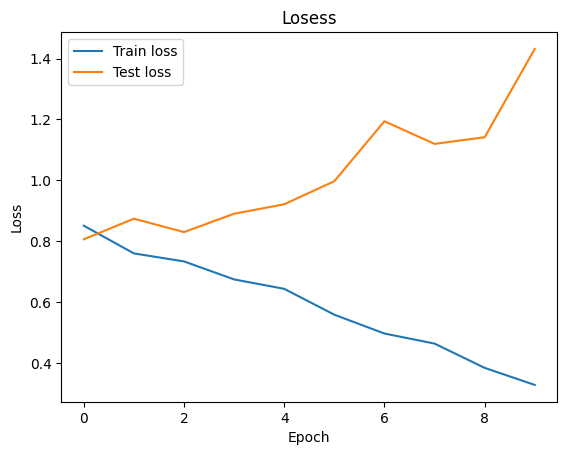

In [33]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))

In [36]:
from torchmetrics.classification import ConfusionMatrix

# Create an instance of the ConfusionMatrix
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)

# Assuming preds and targets are your model's predictions and true labels
cm = confmat(preds, targets)

print(cm)


tensor([[ 37,  40,   7,  11,   9],
        [  8, 130,  11,  20,  22],
        [ 10,  21, 345,   9,  10],
        [  2,  17,   1,  11,   5],
        [  1,   3,   0,   0,   3]])


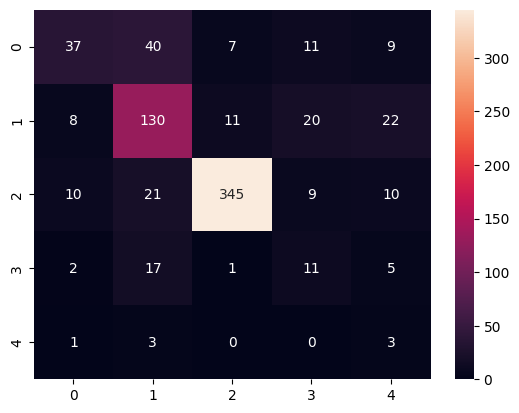

In [39]:
import seaborn as sn

sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()

In [40]:
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 71.76%


In [42]:
from torchmetrics.classification import Precision

# Assuming NUMBER_OF_CLASSES is defined and preds, targets are available
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision_value = precision(preds, targets)

# Print the precision
print(f"Precision: {100 * precision_value:.2f}%")


Precision: 71.76%


In [44]:
from torchmetrics.classification import Recall

# Assuming NUMBER_OF_CLASSES is defined and preds, targets are available
recall_metric = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall_value = recall_metric(preds, targets)

# Print recall
print(f"Recall: {100 * recall_value:.2f}%")


Recall: 71.76%


In [45]:
from torchmetrics.classification import F1Score
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 71.76%
